## Basic Ridge/Lasso

In [1]:
import sys
sys.path.append('../')
from QC import *
# custom PU two-step method
from PU_twostep import twoStep
# pipeline functions
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80)

In [2]:
# basic classifier to use
from sklearn.linear_model import RidgeClassifier, Lasso

In [ ]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

Read in normal human colon sample

In [3]:
s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')
# see how many "good cells" Ken labeled (1)
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [4]:
%%time
# preprocess data with fcc recipe
sc.pp.filter_genes(s1, min_cells=1)
recipe_fcc(s1, X_final='arcsinh_norm', mito_names='^mt-')

CPU times: user 18.6 s, sys: 3.9 s, total: 22.5 s
Wall time: 23.8 s


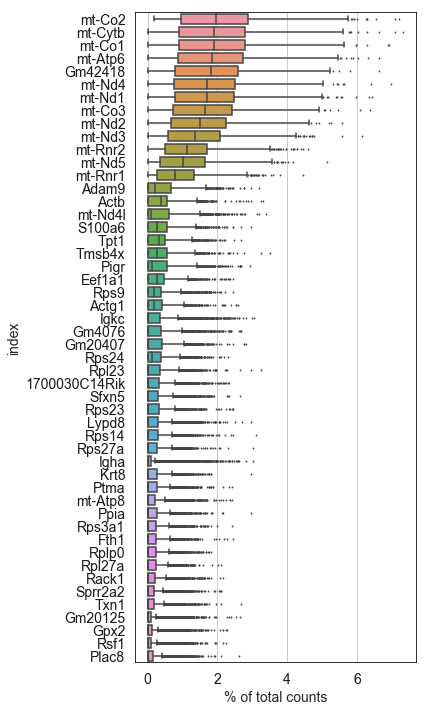

In [5]:
# pct counts in top 50 genes might be useful, as top genes are typically ambient (in empty drops at high frequency)
sc.pl.highest_expr_genes(s1, n_top=50)

### Thresholding
Let's try employing automated threshold picking from [scikit-image](https://scikit-image.org/docs/dev/api/skimage.filters.html) to determine the cutoff between our __empty__ and __non-empty__ droplets.

In [6]:
s1_thresh = auto_thresh_obs(s1, method='otsu')

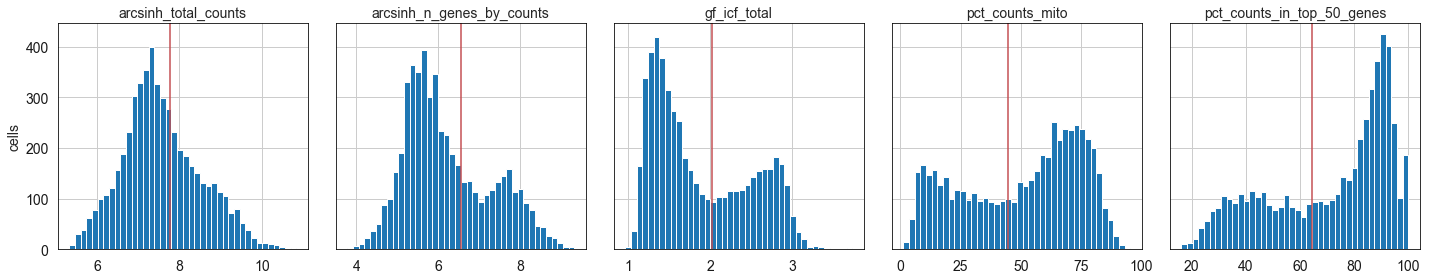

In [7]:
plot_thresh_obs(s1, s1_thresh)

### a couple different ways of visualizing these thresholds vs Ken's filter...

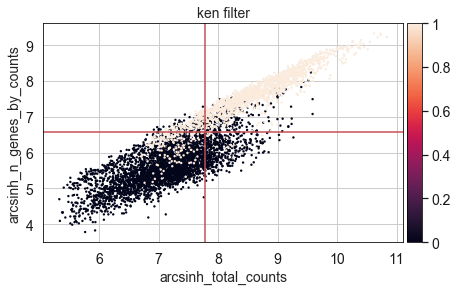

In [8]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='arcsinh_total_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_total_counts'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

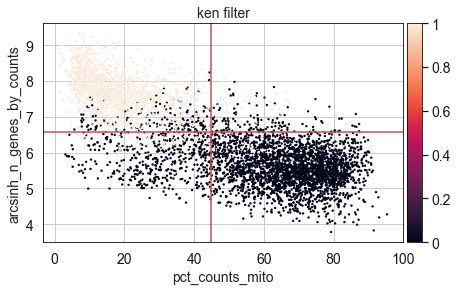

In [9]:
ax = sc.pl.scatter(adata=s1, y='arcsinh_n_genes_by_counts', x='pct_counts_mito', color='ken_filter', show=False)
ax.axvline(s1_thresh['pct_counts_mito'], color='r')
ax.axhline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

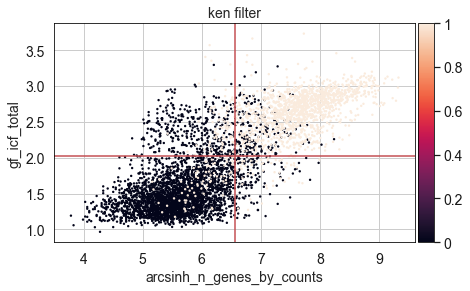

In [10]:
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

---
### Use combination of the above 5 filters to "hard threshold" our dataset and compare to Ken's labels

In [11]:
s1.obs['thresh_filter'] = 0
s1.obs.loc[
    (s1.obs['arcsinh_n_genes_by_counts'] >= s1_thresh['arcsinh_n_genes_by_counts']) & 
    (s1.obs['gf_icf_total'] >= s1_thresh['gf_icf_total']) & 
    (s1.obs['arcsinh_total_counts'] >= s1_thresh['arcsinh_total_counts']) & 
    (s1.obs['pct_counts_mito'] <= s1_thresh['pct_counts_mito']) & 
    (s1.obs['pct_counts_in_top_50_genes'] <= s1_thresh['pct_counts_in_top_50_genes']), 
    'thresh_filter'
] = 1

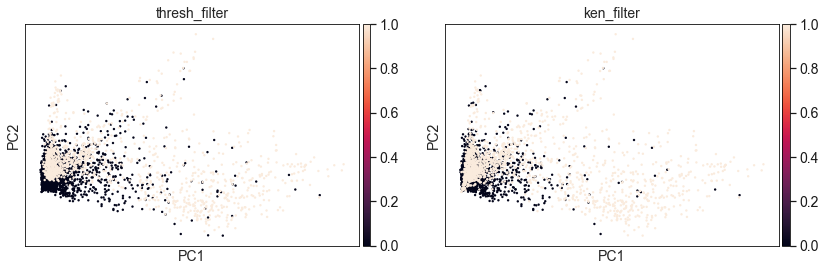

CPU times: user 1.68 s, sys: 425 ms, total: 2.11 s
Wall time: 1.49 s


In [12]:
%%time
# perform 10-component PCA (for training our classifiers later) and look at the two filter labels side-by-side
sc.tl.pca(s1, n_comps=10)
sc.pl.pca(s1, color=['thresh_filter','ken_filter'])

#### Look at set differences with `ken_filter`:

In [13]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

82

In [14]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['thresh_filter']==1])))

356

In [15]:
len(set(s1.obs_names[s1.obs['thresh_filter']==1]) ^ set(s1.obs_names[s1.obs['ken_filter']==1]))

438

In [18]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['thresh_filter'].copy(deep=True) # training labels are from .obs df

In [19]:
rc = RidgeClassifier()
rc.fit(X, y)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)

In [20]:
s1.obs['ridge_score'] = rc.decision_function(X)

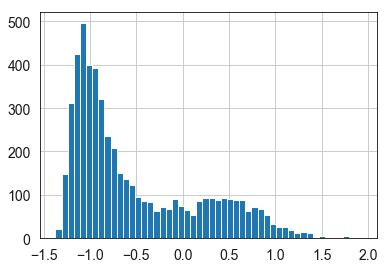

In [21]:
# distribution of scores should be bimodal at 0 and 1
_ = plt.hist(s1.obs['ridge_score'], bins=50)

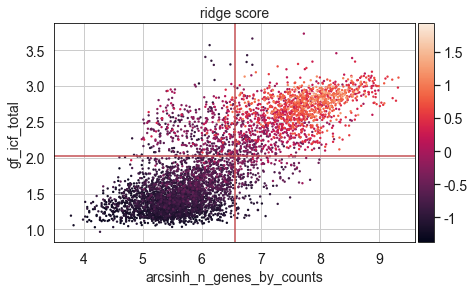

In [22]:
# look at probability scores from classifier
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ridge_score', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

In [23]:
s1.obs['ridge_label'] = rc.predict(X)

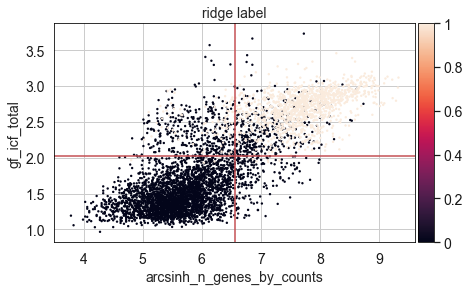

In [28]:
# look at our final labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ridge_label', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

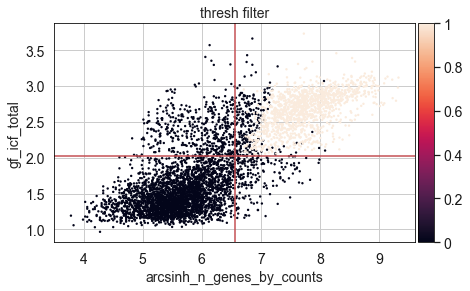

In [26]:
# look at our final labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='thresh_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

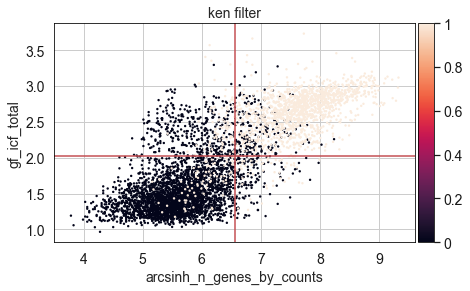

In [27]:
# compare to Ken's labels
ax = sc.pl.scatter(adata=s1, y='gf_icf_total', x='arcsinh_n_genes_by_counts', color='ken_filter', show=False)
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
ax.axhline(s1_thresh['gf_icf_total'], color='r')
plt.show()

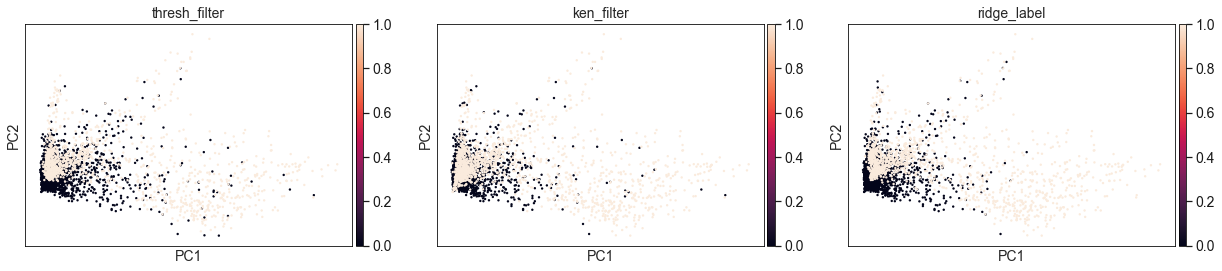

In [29]:
# compare two-step results to threshold filtering and Ken's labels
sc.pl.pca(s1, color=['thresh_filter','ken_filter','ridge_label'])

In [30]:
len(set(s1.obs_names[s1.obs['ridge_label']==1]).difference(set(s1.obs_names[s1.obs['ken_filter']==1])))

130

In [31]:
len(set(s1.obs_names[s1.obs['ken_filter']==1]).difference(set(s1.obs_names[s1.obs['ridge_label']==1])))

392

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [32]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'same'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['ridge_label']==0), 'compare'] = 'ken'
s1.obs.loc[(s1.obs['ridge_label']==1) & (s1.obs['ken_filter']==0), 'compare'] = 'ridge'

In [34]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['ken_filter']==1,:].copy()
s1_ridge = s1[s1.obs['ridge_label']==1,:].copy()

In [35]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^mt-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


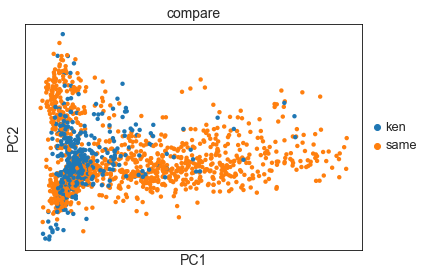

CPU times: user 599 ms, sys: 106 ms, total: 705 ms
Wall time: 354 ms


In [36]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [37]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

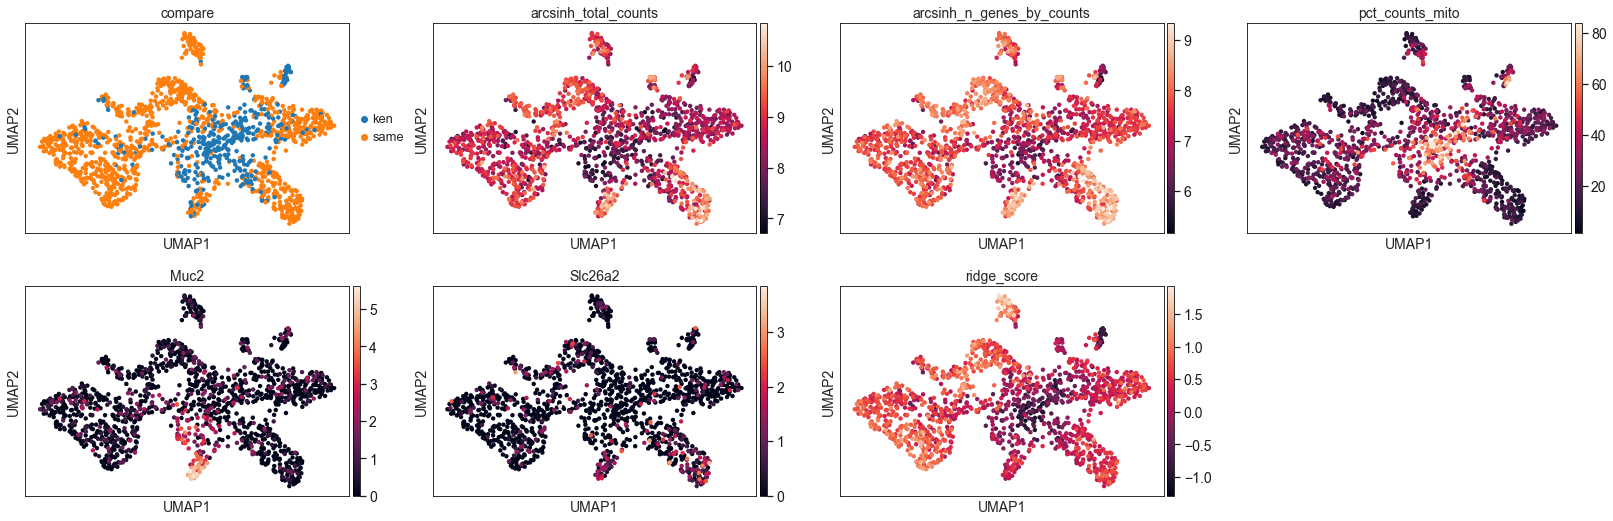

In [39]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Slc26a2','ridge_score'])

---
#### Now do the same on Threshold results

In [46]:
s1_thresh = s1[s1.obs['thresh_filter']==1,:].copy()

In [47]:
# preprocess
s1_thresh.X = s1_thresh.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_thresh, min_cells=1)
recipe_fcc(s1_thresh, X_final='arcsinh_norm', mito_names='^mt-')
s1_thresh.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_thresh.obs['n_genes_by_counts'])

... storing 'compare' as categorical


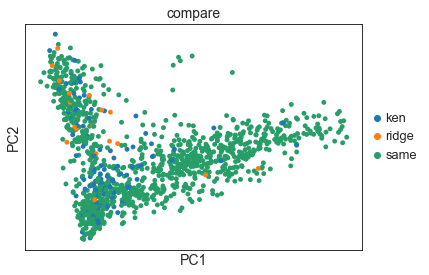

CPU times: user 457 ms, sys: 67.6 ms, total: 524 ms
Wall time: 509 ms


In [48]:
%%time
sc.tl.pca(s1_thresh, n_comps=10)
sc.pl.pca(s1_thresh, color=['compare'])

In [49]:
sc.pp.neighbors(s1_thresh, n_neighbors=int(np.sqrt(s1_thresh.n_obs)))
sc.tl.umap(s1_thresh)

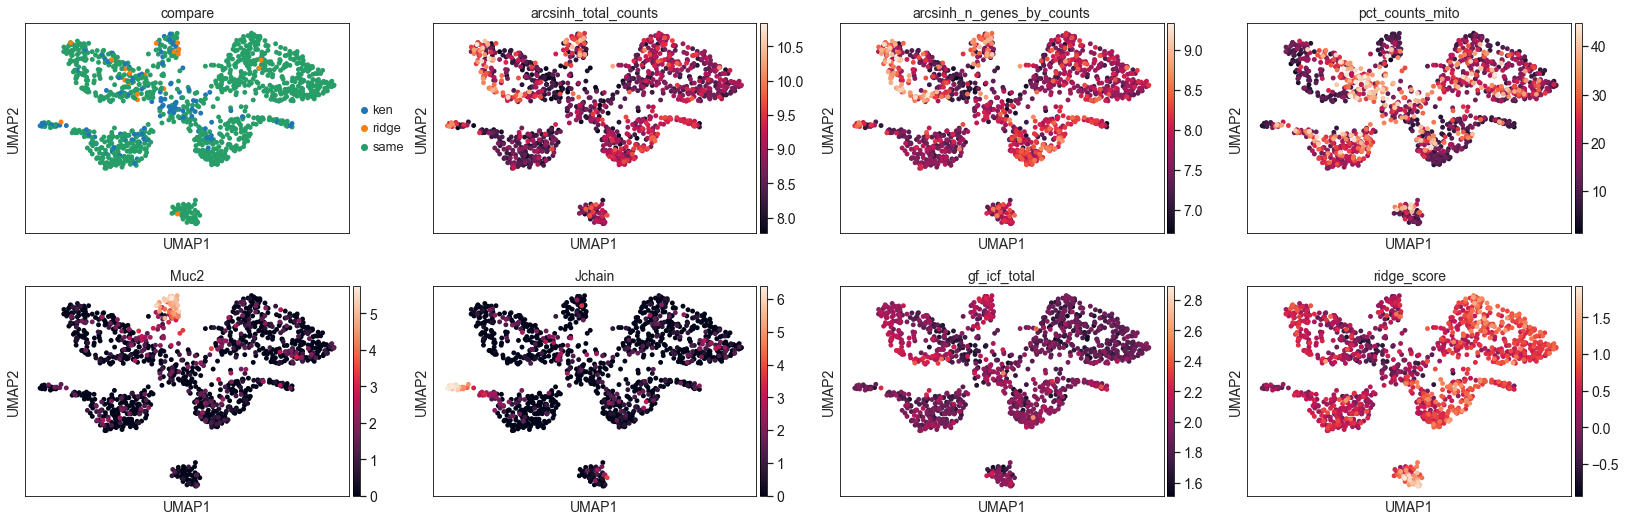

In [50]:
sc.pl.umap(s1_thresh, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total','ridge_score'])

---
#### Now do the same on RidgeClassifier results

In [40]:
# preprocess
s1_ridge.X = s1_ridge.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ridge, min_cells=1)
recipe_fcc(s1_ridge, X_final='arcsinh_norm', mito_names='^mt-')
s1_ridge.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ridge.obs['n_genes_by_counts'])

... storing 'compare' as categorical


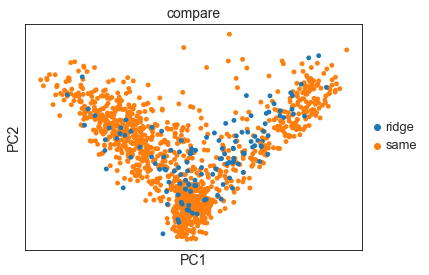

CPU times: user 519 ms, sys: 76.1 ms, total: 595 ms
Wall time: 302 ms


In [41]:
%%time
sc.tl.pca(s1_ridge, n_comps=10)
sc.pl.pca(s1_ridge, color=['compare'])

In [42]:
sc.pp.neighbors(s1_ridge, n_neighbors=int(np.sqrt(s1_ridge.n_obs)))
sc.tl.umap(s1_ridge)

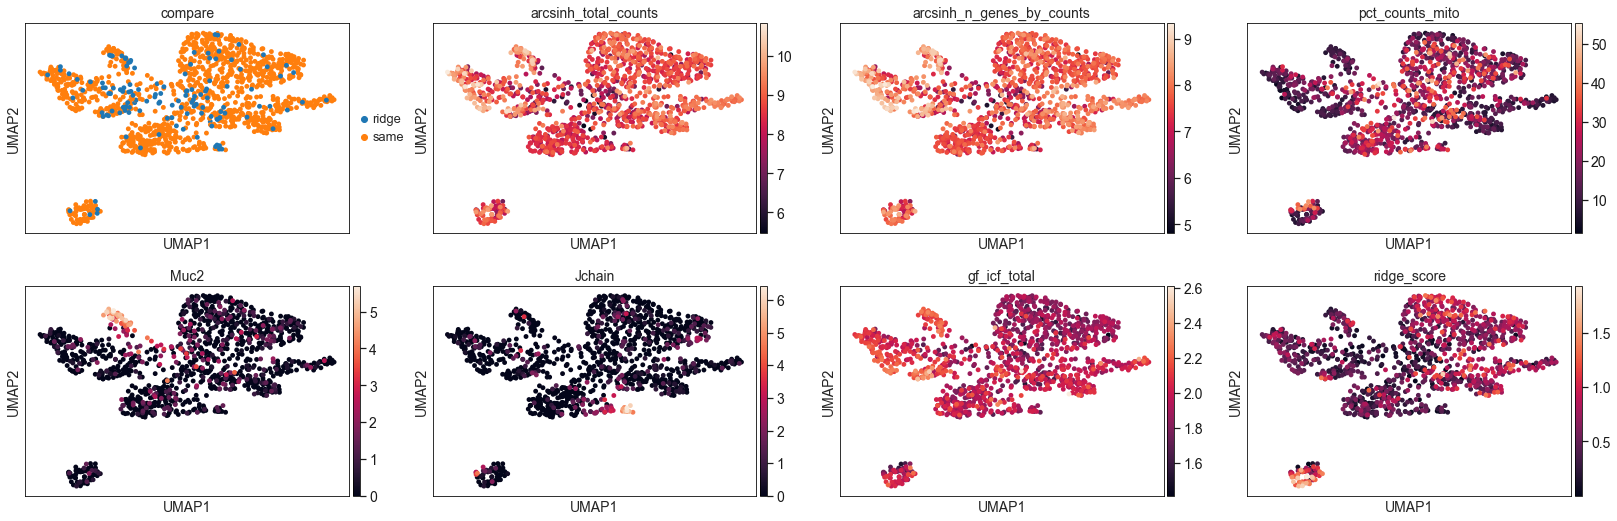

In [45]:
sc.pl.umap(s1_ridge, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total','ridge_score'])

In [52]:
s1_ken.shape

(1536, 27400)

In [53]:
s1_thresh.shape

(1262, 27216)

In [54]:
s1_ridge.shape

(1274, 26973)